# База знань про езотеричні мови програмування

Цей інтерактивний документ Jupyter призначений для роботи з базою знань. Користувач може переглядати факти бази знань у вигляді таблиці або графа, створювати запити до бази знань, додавати (або видаляти) факти вручну або шляхом застосування механізму логічного виведення.

База знань складається з множини фактів і множини правил логічного виведення. Факти бази знань подані як триплети (суб'єкт, предикат, об'єкт) або (s, p, o). Триплети зберігаються у файлі формату CSV. Для зручного оброблення за допомогою пакету pandas ці триплети завантажуються в таблицю df (DataFrame). Ця таблиця df створюється в модулі mykb.

Віджети IPyWidgets (текстові поля і кнопки) дозволяють інтерактивну роботу з БЗ - пошук триплетів за шаблоном, додавання нових триплетів та їх видалення.

Для візуалізації графа бази знань використовуються пакети NetworkX (створює граф) та Matplotlib (візуалізує граф). NetworkX також можна використати для застосування різноманітних алгоритмів на графах.

Правила і машина виведення описані в модулі example3. Правила логічного виведення (rule1, rule2) дозволяють виводити нові факти за допомогою машини логічного виведення (reasoner). Машина виведення виконує "пряме виведення" та використовує підхід "а-ля RETE" для пришвидшення алгоритму, тобто будує дерево триплетів для швидкого пошуку.

Послідовність запуску через JupyterLite:

1. Відкрийте в браузері https://jupyter.org/try-jupyter/lab/
2. Перетягніть у File Browser (зліва) файли TextSelectInteractKB.ipynb, kb.csv, mykb.py, example3.py
3. Запустіть TextSelectInteractKB.ipynb і виконайте усі комірки

In [360]:
import ipywidgets, pandas
from IPython.display import display
import sys
import networkx
import matplotlib.pyplot as plt

In [361]:
# імпортуємо таблицю з фактами бази знань (s, p, o)
from mykb import df

In [362]:
# приклад запиту до бази знань:
# вивести таблицю усіх фактів (s, p, o), де s містить "Befunge"
df[
    df["s"].str.contains("Befunge")
]

,s,p,o
3,Befunge,особливість,код як лабіринт
4,Befunge,перевага,нестандартне мислення
5,Befunge,недолік,відсутність структурованості


In [363]:
# вивести таблицю усіх фактів (s, p, o), де s містить "Befunge" і p містить "перевага"
df[
    df["s"].str.contains("Befunge") &
    df["p"].str.contains("перевага")
]

,s,p,o
4,Befunge,перевага,нестандартне мислення


In [364]:
output_table = ipywidgets.Output()
def f1(b):
    global fdf
    with output_table:
        output_table.clear_output(wait=True)
        fdf = df[
            df["s"].str.contains(s.value, case=False, na=False) &
            df["p"].str.contains(p.value, case=False, na=False) &
            df["o"].str.contains(o.value, case=False, na=False)
        ]
        display(fdf)
        print(f"Знайдено {len(fdf)} фактів.")

In [365]:
output_log = ipywidgets.Output()
def on_button_clicked(b):
    global df
    ndf = pandas.DataFrame([[s.value, p.value, o.value]], columns=["s", "p", "o"])
    if b.description == "Add to KB":
        df = pandas.concat([df, ndf], ignore_index=True)
    elif b.description == "Remove from KB":
        df = pandas.concat([df, ndf], ignore_index=True).drop_duplicates(keep=False, ignore_index=True)
    df.to_csv("kb.csv", index=False)
    with output_log:
        output_log.clear_output(wait=True)
        print(f"{b.description}: ({s.value}, {p.value}, {o.value})")
    f1()  # оновити таблицю після змін

In [366]:
s = ipywidgets.Text(description="Суб'єкт:", placeholder="Введіть назву мови...")
p = ipywidgets.Dropdown(
    options=["", "перевага", "недолік", "особливість"],
    description="Предикат:"
)
o = ipywidgets.Text(description="Об'єкт:", placeholder="Введіть характеристику...")

# --- кнопки ---
button_search = ipywidgets.Button(description="Search KB")
button_add = ipywidgets.Button(description="Add to KB", button_style="success")
button_remove = ipywidgets.Button(description="Remove from KB", button_style="danger")

button_search.on_click(f1)
button_add.on_click(on_button_clicked)
button_remove.on_click(on_button_clicked)

# --- компонування інтерфейсу ---
controls = ipywidgets.VBox([s, p, o])
buttons = ipywidgets.HBox([button_search, button_add, button_remove])
ui = ipywidgets.VBox([controls, buttons, output_log, output_table])

display(ui)
f1(button_search)

In [367]:
#df = df.drop(index=[4]) # видалити за індексом

In [368]:
# створити орієнтований граф, у якого вершинами є s та o, а дугами - p
G=networkx.DiGraph()
for r in fdf.itertuples(): # для кожного рядка таблиці
    G.add_edges_from([(r.s, r.o)], label=r.p) # створити вершини і дугу

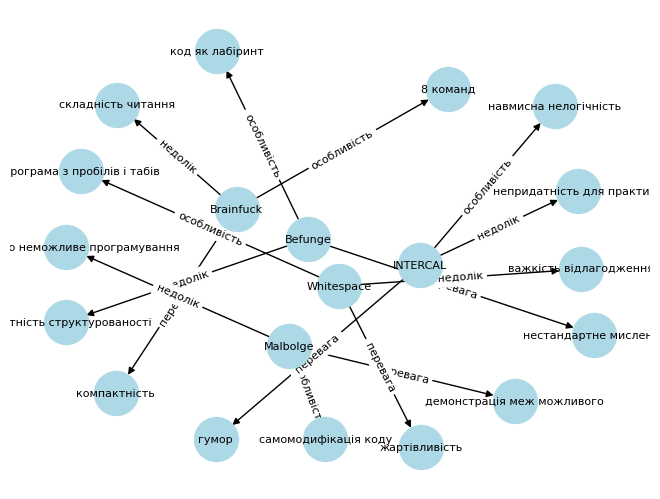

In [369]:
pos = networkx.spring_layout(G, k=0.1, seed=42)
edge_labels = networkx.get_edge_attributes(G, 'label')
networkx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=1000, font_size=8)
networkx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)
plt.show()

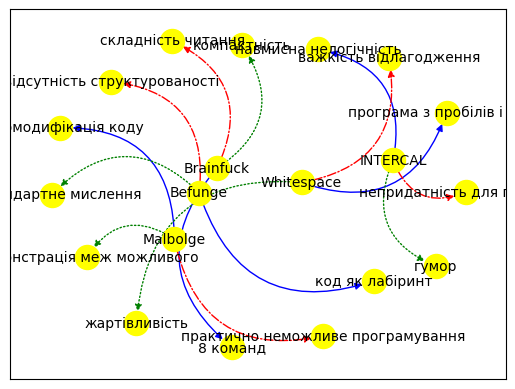

In [370]:
# списки дуг "перевага" та "недолік"
edges_q=[(u,v) for u,v,e in G.edges(data=True) if e['label']=="особливість"]
edges_p=[(u,v) for u,v,e in G.edges(data=True) if e['label']=="перевага"]
edges_n=[(u,v) for u,v,e in G.edges(data=True) if e['label']=="недолік"]
pos = networkx.spring_layout(G) # вибрати алгоритм візуалізації графа
# нарисувати вузли, мітки і дуги
networkx.draw_networkx_nodes(G, pos, node_color='yellow')
networkx.draw_networkx_labels(G, pos, font_size=10)
networkx.draw_networkx_edges(G, pos, edgelist=edges_q, edge_color='blue', style='-', connectionstyle='arc3, rad=0.5')
networkx.draw_networkx_edges(G, pos, edgelist=edges_p, edge_color='green', style=':', connectionstyle='arc3, rad=0.5')
networkx.draw_networkx_edges(G, pos, edgelist=edges_n, edge_color='red', style='-.', connectionstyle='arc3, rad=0.5')
# зберегти граф у форматі SVG
plt.savefig("graph.svg", format="svg")

In [371]:
# імпорт правил і машини логічного виведення з модуля example3
from example3 import *

In [372]:
# наповнити множину F усіма фактами
F=set()
for row in df.itertuples():
    F.add((row.s, row.p, row.o))
# вивести нові факти за правилами rule1, rule2
A=reasoner(F, [rule1, rule2], ["перевага"], ["недолік"])
print(A) # усі факти
print(A-F) # нові факти

{('Malbolge', 'перевага', 'демонстрація меж можливого'), ('Malbolge', 'недолік', 'практично неможливе програмування'), ('Brainfuck', 'особливість', '8 команд'), ('Befunge', 'недолік', 'відсутність структурованості'), ('складність читання', 'недолік', 'Brainfuck'), ('Brainfuck', 'недолік', 'складність читання'), ('практично неможливе програмування', 'недолік', 'Malbolge'), ('Malbolge', 'особливість', 'самомодифікація коду'), ('INTERCAL', 'перевага', 'гумор'), ('Befunge', 'особливість', 'код як лабіринт'), ('Whitespace', 'перевага', 'жартівливість'), ('Befunge', 'перевага', 'нестандартне мислення'), ('важкість відлагодження', 'недолік', 'Whitespace'), ('INTERCAL', 'особливість', 'навмисна нелогічність'), ('INTERCAL', 'недолік', 'непридатність для практики'), ('непридатність для практики', 'недолік', 'INTERCAL'), ('Brainfuck', 'перевага', 'компактність'), ('Whitespace', 'недолік', 'важкість відлагодження'), ('відсутність структурованості', 'недолік', 'Befunge'), ('Whitespace', 'особливіст